<a href="https://colab.research.google.com/github/carlibeisel/Drains_Lower_Boise_River/blob/main/*irrigation_change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Identifying Pivot Irrigated Land
By: Carli Beisel

Adapted from David Ketchum (Github: dgketchum)

Created on May 13, 2024

Modified on May 17, 2024

Purpose:

1) Crop Irrigated Fields Shapefiles to each drainshed in the Treasure Valley.

2) Finds pivot irrigated areas in irrigation shapefile. This code assumes that circles/arcs in the landscape represent pivot irrigation. This script finds arcs in polygon geometries of the shapefile, and writes a new attribute called "pivot". This Script is directly from David Ketchum.

3) Sums area of pivot irrigation for each shapefile and combines into one dataframe. The created dataframe that has two columns: year and total acres of pivot irrigation.

4) Generates a regression plot of irrigation change over time with the genderated dataframe.

5) Creates a new dataframe based on regression for input into the model.

## 1. Crop Irrigated Fields Shapefiles to each drainshed.

In [ ]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
! pip install pandarallel
from pandarallel import pandarallel
import glob
import os
from shapely.geometry import shape

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ------------------------------------------ #
#  Crop Irrigated Field Shapefile to Drains  #
# ------------------------------------------ #

drainsheds = gpd.read_file('/content/drive/MyDrive/Data/Drains_Lower_Boise_River/data_input/drain_delineation/Drains_Merge_07072022.shp')
names = drainsheds['Name']
irrigated_field_files = glob.glob('/content/drive/MyDrive/Data/irrigation_shapefiles/irrigated_land_only/*.shp')
output_dir = '/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigated_fields'

# Create output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Create function to crop shapefile to each drainshed area
def crop_shapefiles(irrigated_field_files, drainsheds, output_dir):
    mask_gdf = drainsheds
    for field_file in irrigated_field_files:
        input_gdf = gpd.read_file(field_file)
        if input_gdf.crs != mask_gdf.crs:
            input_gdf = input_gdf.to_crs(mask_gdf.crs)
        for i, mask_feature in mask_gdf.iterrows():
            mask_geom = mask_feature['geometry']
            mask_name = mask_feature['Name']
            cropped_gdf = gpd.overlay(input_gdf, gpd.GeoDataFrame(geometry=[mask_geom], crs=mask_gdf.crs), how='intersection')
            field_name = os.path.splitext(os.path.basename(field_file))[0]
            output_filename = os.path.join(output_dir, f"{field_name}_{mask_name}_cropped.shp")
            cropped_gdf.to_file(output_filename)
            print(f"Cropped shapefile saved to {output_filename}")

crop_shapefiles(irrigated_field_files, drainsheds, output_dir)

## 2. Find pivot irrigated areas in each drain's irrigation shapefile.

This code assumes that circles/arcs in the landscape represent pivot irrigation. This script finds arcs in polygon geometries of the shapefile, and writes a new attribute called "pivot".

This script is directly from David Ketchum.

In [ ]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
! pip install pandarallel
from pandarallel import pandarallel
import glob
import os
from shapely.geometry import shape

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ------------------------------------------ #
#       Create Pivot_Test Function           #
# ------------------------------------------ #

min_arc = 10
tol = 0.22

def area_flood_irrigation(shp):
    df = gpd.read_file(shp)
    p = df[df['IType'] == 'P']['geometry']
    p = np.sum([g.area for g in p])
    s = df[df['IType'] == 'S']['geometry']
    s = np.sum([g.area for g in s])
    f = df[df['IType'] == 'F']['geometry']
    f = np.sum([g.area for g in f])
    t = p + s + f
    print('pivot: {:.3f} sqkm, {:.3f}'.format(p / 1e6, p / t))
    print('sprinkler: {:.3f} sqkm, {:.3f}'.format(s / 1e6, s / t))
    print('flood: {:.3f} sqkm, {:.3f}'.format(f / 1e6, f / t))

def bearing(a, b):
    lat1 = np.radians(a[0])
    lat2 = np.radians(b[0])

    diffLong = np.radians(b[1] - a[1])

    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1)
                                       * np.cos(lat2) * np.cos(diffLong))

    return np.arctan2(x, y)

def find_arcs(g):
    verts = g.exterior.coords
    arc_ct, b_prev = 0, np.pi
    for i, v in enumerate(verts):
        try:
            next = verts[i + 1]
        except IndexError:
            break
        b = bearing(v, next)
        diff = b - b_prev
        if diff < tol:
            arc_ct += 1
            if arc_ct >= min_arc:
                return True
        else:
            arc_ct = 0
        b_prev = b

    return False

def pivot_test(in_shp, out_shp):
    pandarallel.initialize(use_memory_fs=False, progress_bar=True)

    df = gpd.read_file(in_shp).explode()
    df.index = range(df.shape[0])
    print('{} features'.format(df.shape[0]))
    df['arc'] = df.geometry.apply(lambda g: find_arcs(g))
    df['arc'] = df.geometry.parallel_apply(find_arcs)
    df.to_file(out_shp, crs='epsg:4326')
    print('{} of {} features have an arc'.format(np.count_nonzero(df['arc']), df.shape[0]))

In [ ]:
# --------------------------------------------------- #
#        Run Pivot_Test for each Shapefile            #
# --------------------------------------------------- #

years = np.arange(1987,2022)
files = glob.glob('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigated_fields/*.shp')

if __name__ == '__main__':
    for file in files:
       base_name = file.split('/')[-1].split('.')[0].replace('irrigated_', '')
       base_name = base_name.replace('_cropped', '')  # Remove "_cropped"
       for year in years:
            out_shp = f'/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_pivot/{base_name}_arcs.shp'
            pivot_test(file, out_shp)

## 3. Sums area of pivot irrigated land and total irrigated land for each shapefile and combines into one dataframe.

The created dataframe that has three columns: 1) year, 2) total pivot irrigated acres, and 3) total acres irrigated.

In [11]:
# ------------------------ #
#   Import Libraries       #
# ------------------------ #
!pip install geopandas shapely
import geopandas as gpd
import glob
import pandas as pd
import re
from shapely.geometry import MultiPolygon #for shapefiles with holes or difficult shapes
import os

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# --------------------------------------------------- #
#   Sum Total Irrigated Area for Each Drainshed       #
# --------------------------------------------------- #
# Define a function to extract the year, name, and whether the file is cropped from the filename
def parse_filename(filename):
    base_name = os.path.splitext(os.path.basename(filename))[0]
    match = re.match(r'(\d{4})_irrigated_(.*?)_cropped', base_name)
    year = int(match.group(1))
    name = match.group(2).replace('_', ' ')

irrigated_fields = glob.glob('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigated_fields/*.shp'))

irrigated_acres = []
for shp in irrigated_fields:
    year, name = parse_filename(shp)
    gdf = gpd.read_file(shp)
    total_area_acres = gdf['Acres'].sum()
    irrigated_acres.append({'Year': year, 'Name': name, 'Total Irrigated Acres': total_area_acres})


all_data = pd.DataFrame(irrigated_acres)
all_data.to_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/all_irrigated_fields.csv', index=False)

CSV file saved to /content/drive/MyDrive/Data/Model Modifications/irrigation_change/all_irrigated_fields.csv


In [27]:
# --------------------------------------------------- #
#  Sum Total Pivot Irrigated Area for Each Drainshed  #
# --------------------------------------------------- #


# Define a function to extract the year and name from the filename
def parse_filename(filename):
    # Extract the base name without extension
    base_name = os.path.splitext(os.path.basename(filename))[0]
    # Use regex to capture year and name
    match = re.match(r'(\d{4})_(.*?)_arcs', base_name)
    if match:
        year = int(match.group(1))
        name = match.group(2).replace('_', ' ')
        return year, name
    return None, None

# List all shapefiles in the input folder
shapefiles = glob.glob('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_pivot/*.shp')

# Initialize a list to store data
irrigated_acres = []

# Iterate over each shapefile
for shp in shapefiles:
    year, name = parse_filename(shp)
    gdf = gpd.read_file(shp)
    total_area_acres = gdf['arc'].sum()
    irrigated_acres.append({'Year': year, 'Name': name, 'Pivot Irrigated Acres': total_area_acres})

pivot_data = pd.DataFrame(irrigated_acres)

# Save the DataFrame to a CSV file
pivot_data.to_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/pivot_irrigated_fields.csv', index=False)


In [35]:
# --------------------------------------------------- #
#  Combine Dataframes & Calculate Proportion Metric   #
# --------------------------------------------------- #

pivot = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/pivot_irrigated_fields.csv')
all = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/all_irrigated_fields.csv')

merged_data = pd.merge(pivot, all, on=['Year', 'Name'], how='inner')
print(merged_data)

merged_data['Pivot Proportion'] = merged_data['Pivot Irrigated Acres'] / merged_data['Total Irrigated Acres']
print(merged_data)
merged_data.to_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigation_change.csv', index=False)

     Year             Name  Pivot Irrigated Acres  Total Irrigated Acres
0    1987     West Hartley                      0            4722.584324
1    1987   Sand Run Gulch                     64           24421.949064
2    1987      Eagle Drain                      0            4944.132809
3    1987      Mason Drain                      0            1381.270030
4    1987      Mason Creek                     39           37334.311807
..    ...              ...                    ...                    ...
105  2022     Conway Gulch                      2            6476.808475
106  2022     ThurmanDrain                      4             155.390976
107  2022  North Middleton                      4            2753.039580
108  2022  South Middleton                      8            5890.767630
109  2022     Indian Creek                    164           23195.494185

[110 rows x 4 columns]
     Year             Name  Pivot Irrigated Acres  Total Irrigated Acres  \
0    1987     West Hartl

## 4. Generate a regression plot of irrigation change over time for each drainshed.

In [67]:
# ------------------------ #
#   Import Libraries       #
# ------------------------ #

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import numpy as np

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# ------------------------------------------ #
#  Read in Dataframe and Define Varaibles    #
# ------------------------------------------ #
df = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigation_change.csv')

names = df['Name'].unique()
year = df['Year']

prop = df['Pivot Proportion']

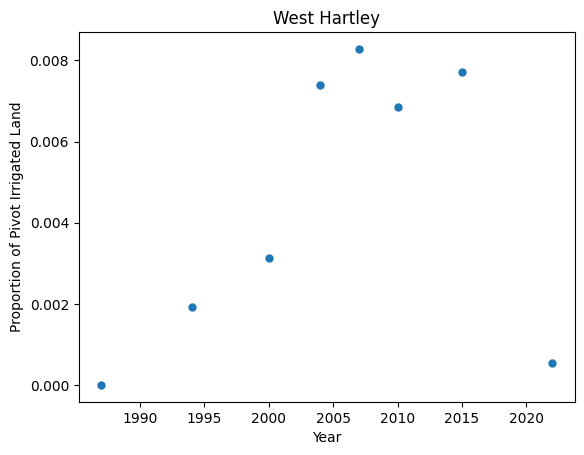

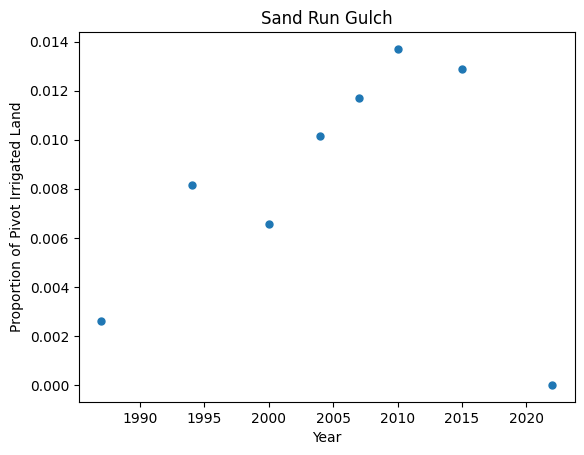

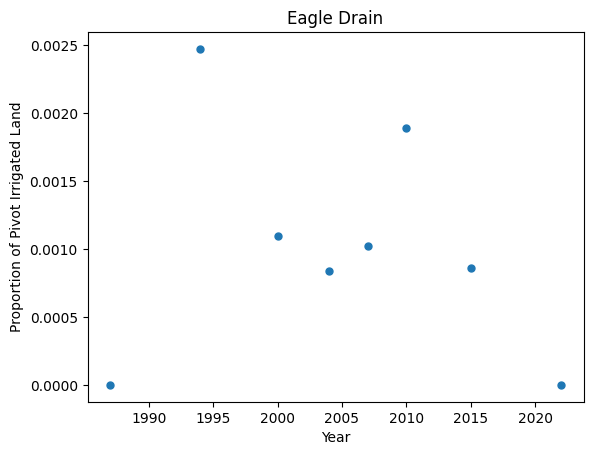

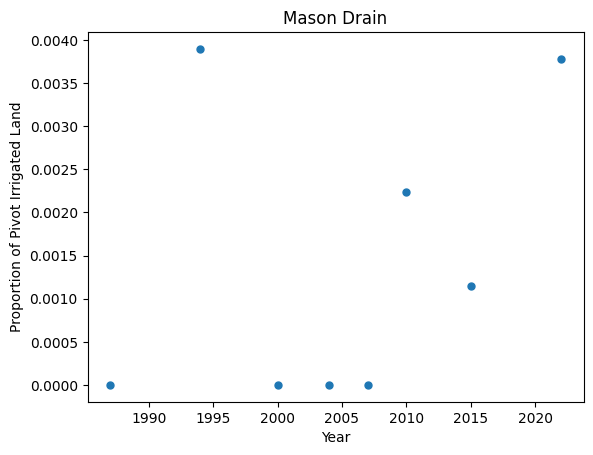

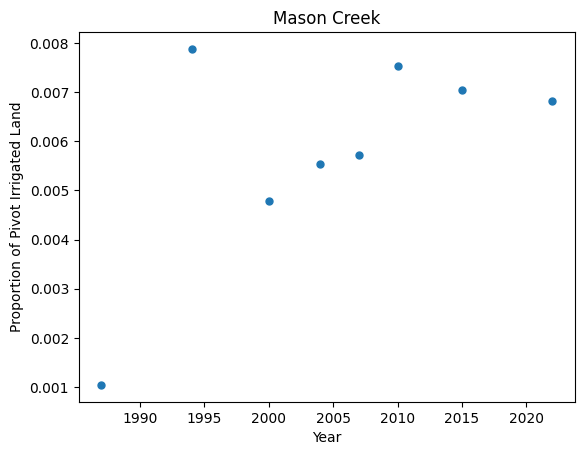

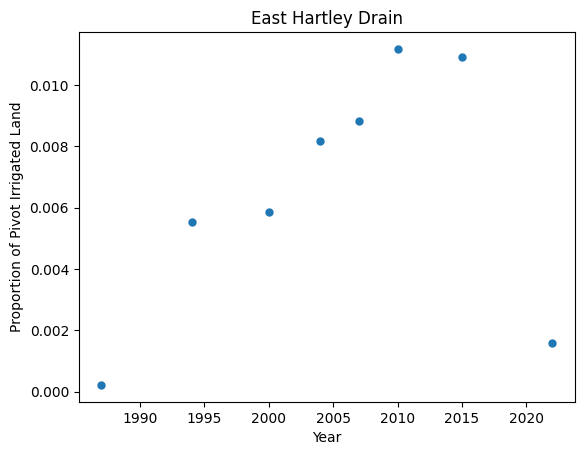

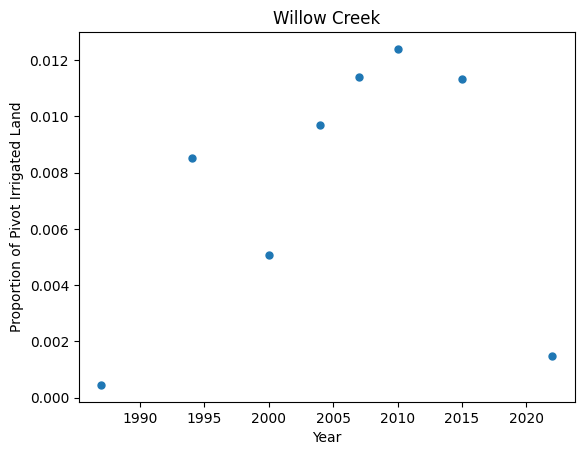

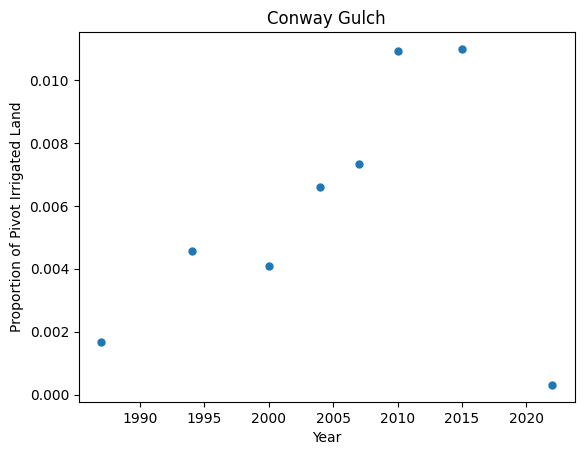

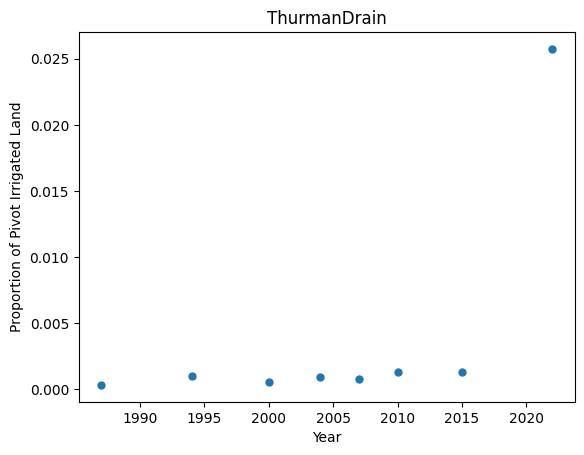

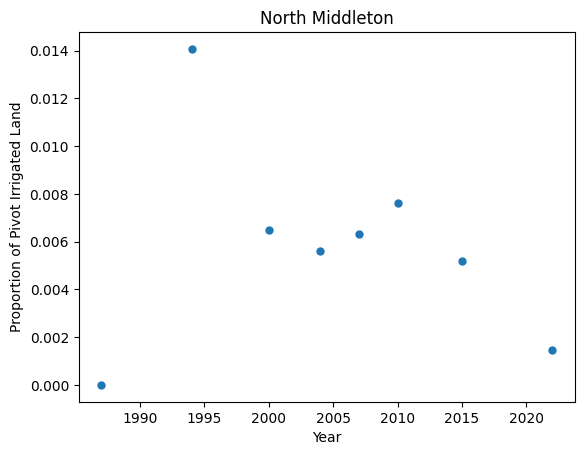

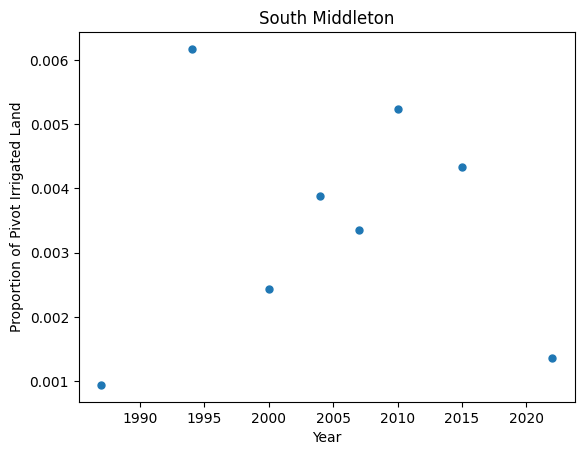

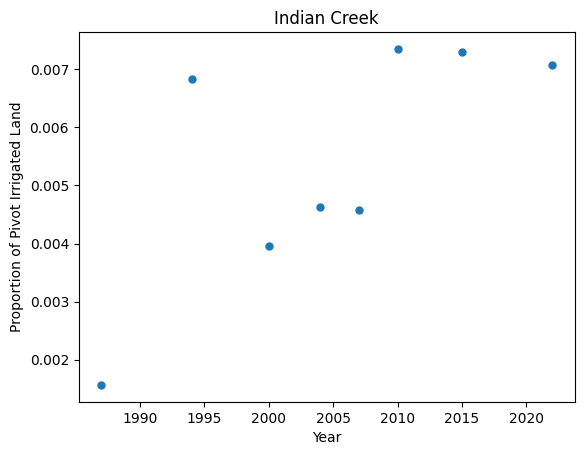

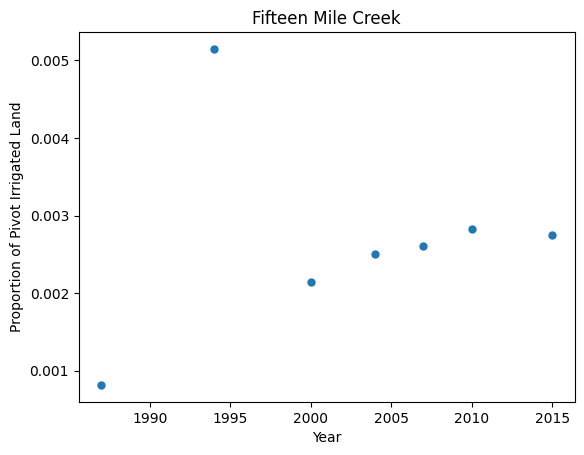

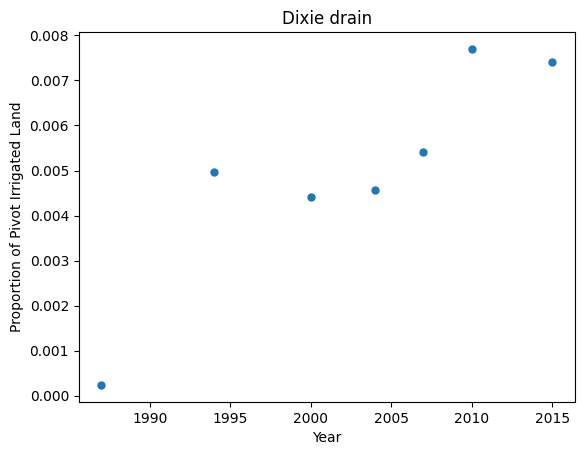

In [57]:
# -------------------------- #
#  Plot for each Drainshed   #
# -------------------------- #

names = df['Name'].unique()
grouped = df.groupby('Name')

# Iterate over each unique name
for i in names:
    temp_df = grouped.get_group(i)

    # Extract the year and proportion for plotting
    year = temp_df['Year']
    prop = temp_df['Pivot Proportion']

    plt.plot(year, prop, 'o', markersize=5)
    plt.title(f"{i}")
    plt.xlabel('Year')
    plt.ylabel('Proportion of Pivot Irrigated Land')
    plt.show()

In [53]:
# -------------------------- #
#  Plot for ALL Drainsheds   #
# -------------------------- #

df = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/drainshed_irrigation_change.csv')

grouped = df.groupby('Name')
year = df['Year']

fig = go.Figure()

# Loop through the grouped data
for year, data in grouped:
    fig.add_trace(go.Scatter(
        x=data['Year'],
        y=data['Pivot Proportion'],
        mode='lines',
        name=str(year)
    ))

fig.update_layout(
    title="Irrigation Change in the Treasure Valley",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Proportion')
)

fig.show()

In [65]:
# ------------------------------------ #
#  Regresion plot for each Drainshed   #
# ------------------------------------ #

# Group the data by 'Name' or any other relevant column
grouped = df.groupby('Name')

# Create a directory to save the plots if it doesn't exist
output_dir = '/content/drive/MyDrive/Data/Model Modifications/irrigation_change/Figures/drainshed_regressions/'
os.makedirs(output_dir, exist_ok=True)

# Iterate over each group
for name, group in grouped:
    # Initialize and fit the linear regression model for each group
    model = LinearRegression()
    X = group[['Year']]
    y = group['Pivot Proportion']
    model.fit(X, y)

    # Predict values using the fitted model
    group['Predicted_Acres'] = model.predict(X)

    # Calculate the R² value
    r_squared = model.score(X, y)

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=group, x='Year', y='Pivot Proportion', marker='o', label='Actual Data')
    plt.plot(group['Year'], group['Predicted_Acres'], color='red', label='Regression Line')

    # Customize the plot
    plt.title(f'Regression for {name}')
    plt.xlabel('Year')
    plt.ylabel('Proportion of Land Irrigated with Pivot')
    plt.grid(True)
    plt.legend()

    # Annotate the R² value on the plot
    plt.text(
        0.05, 0.85, f'R²: {r_squared:.2f}',
        transform=plt.gca().transAxes, fontsize=12, verticalalignment='top'
    )

    # Save the plot
    plot_filename = f'{name}_regression.tiff'
    plt.savefig(os.path.join(output_dir, plot_filename), format='tiff', dpi=300)
    plt.close()  # Close the plot to avoid overlapping plots

Plots saved successfully.


## 5. Create dataframe from regression data for input into GLMM model

In [71]:
# ----------------------------------------- #
#  Build Data off of Regression for Model   #
# ----------------------------------------- #

grouped = df.groupby('Name')

all_predictions = pd.DataFrame()

for name, group in grouped:
    # Initialize and fit the linear regression model for each group
    model = LinearRegression()
    X = group[['Year']]
    y = group['Pivot Proportion']
    model.fit(X, y)

    # Predict values for the years 1987 to 2022
    future_years = pd.DataFrame({'Year': np.arange(1987, 2023)})
    predicted_proportions = model.predict(future_years)

    # Create a DataFrame for the predictions
    predictions_df = pd.DataFrame({
        'Year': future_years['Year'],
        'Name': name,
        'Predicted_Proportion': predicted_proportions
    })

    # Append the predictions to the overall DataFrame
    all_predictions = pd.concat([all_predictions, predictions_df], ignore_index=True)

all_predictions.to_csv('/content/drive/MyDrive/Data/Model Modifications/irrigation_change/irrigation_model_input.csv', index=False)